In [1]:
#Import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.datasets import make_regression
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

# 5.6 Random Forest

## 5.6.1 A little bit of theory

An often used technique in machine learning are random forests. Basically they are [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning), or in programmers terms, if-then-else structures, like the one shown below.

<img src="figures/tree.png" width=70%>

Decision trees are know to over-fit a lot because they just learn the train set by heart and store it. Random forests on the other hand combine multiple different (randomly initialized) decision trees that all over-fit in their own way. But by combining their output using a voting mechanism, they tend to cancel out eachothers mistakes. This approach is called an [ensemble](https://en.wikipedia.org/wiki/Ensemble_learning) and can be used for any combination of machine learning techniques. A schematical representation of how such a random forest works is shown below.

<img src="figures/random_forest.jpg">

Now let's try to use a random forest to solve the churn problem. (see [`sklearn.ensemble.RandomForestClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

**Some random forest parameters you can set to avoid overfitting:**
- n_estimators: number of trees you will grow
- max_depth: max number of splits each tree can make
- max_features: max features to consider when making a tree split
- min_samples_split: determines while building the tree how many data points you need at least before you create another split (this is an additional if-else structure)
- min_samples_leaf: sets the minimum amount of data points you have in each leaf

## 5.6.2 Importing data + making train/test data

We will try to predict if a customer of a firm will churn at the hand of several variables

In [2]:
#make objects
df = pd.read_csv("data/churn.csv")
df = df.drop(["Phone", "Area Code", "State"], axis=1)
X = df.drop(["Churn"], axis=1)
y = df['Churn'].values.tolist()

# Split the data into test and training (30% for test)
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state = 123)

In [3]:
#distribution churners and non churners
df.Churn.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

## 5.6.3 Model building

In [6]:
rf = RandomForestClassifier(n_estimators=100)

# Train the classifier using the train data
rf = rf.fit(X_train, Y_train)

# Validate the classifier
accuracy = rf.score(X_test, Y_test)
print('Accuracy on test set: ' + str(accuracy))

# Make a confusion matrix
prediction = rf.predict(X_test)

conf_matrix = pd.DataFrame(
    confusion_matrix(Y_test, prediction), 
    columns=["Predicted False", "Predicted True"], 
    index=["Actual False", "Actual True"]
)

conf_matrix

Accuracy on test set: 0.949


,Predicted False,Predicted True
Actual False,851,15
Actual True,36,98


0.9031832753093654


<Figure size 432x288 with 0 Axes>

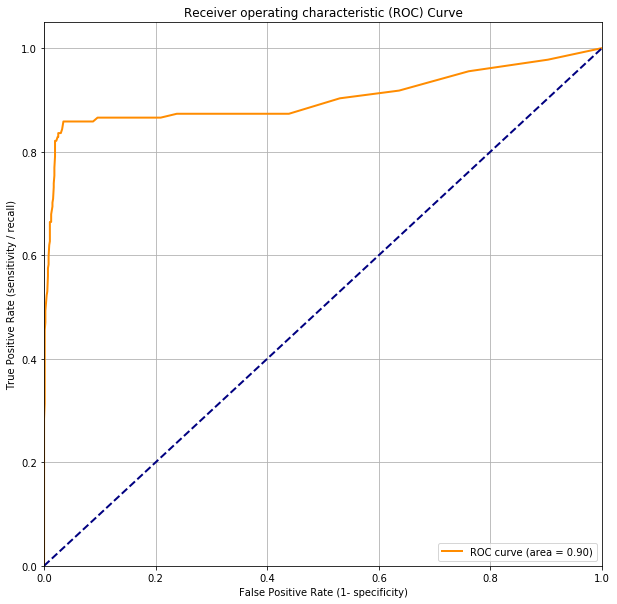

In [8]:
#calculate probabilities that customer will churn for test set
probs = rf.predict_proba(X_test)

fpr, tpr, threshold = roc_curve(Y_test, probs[:,1])

#calculate area under curve
roc_auc = auc(fpr,tpr)
print(roc_auc)

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate (sensitivity / recall)')
plt.xlabel('False Positive Rate (1- specificity)')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.6.4 Variable importance

Calculate the mean decrease in node impurity  / error rate from splitting on 1 variable
- Classification: decrease in Gini index or accuracy
- Regression: decrease in RSS or MSE

In [9]:
# We'll use this library to make the display pretty
# install this module using: 
# $ conda install tabulate
from tabulate import tabulate

headers = ["name", "score"]
values = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                score
Day Charge      0.164684
Day Mins        0.132804
CustServ Calls  0.116975
Eve Charge      0.0681369
Int'l Plan      0.0665974
Eve Mins        0.0629799
Intl Calls      0.0508753
Intl Mins       0.0423216
Night Charge    0.040158
Intl Charge     0.039796
VMail Message   0.0349127
Night Mins      0.0347494
Account Length  0.031925
Day Calls       0.0312487
Night Calls     0.0306013
Eve Calls       0.028227
VMail Plan      0.0230082


In [10]:
print(values)

[('Day Charge', 0.16468423854512984), ('Day Mins', 0.1328037454982449), ('CustServ Calls', 0.11697471759044836), ('Eve Charge', 0.06813690427168181), ("Int'l Plan", 0.06659738590684973), ('Eve Mins', 0.06297986394648275), ('Intl Calls', 0.05087531017854106), ('Intl Mins', 0.04232164195609609), ('Night Charge', 0.04015799482376806), ('Intl Charge', 0.0397960077611074), ('VMail Message', 0.03491267664106367), ('Night Mins', 0.034749354427755626), ('Account Length', 0.031924975274371936), ('Day Calls', 0.03124868677656489), ('Night Calls', 0.0306013447794512), ('Eve Calls', 0.02822695760375563), ('VMail Plan', 0.02300819401868719)]


## 5.6.5 Task 4: Hiring revisited

- Redo the previous excercise, using random forests.
- Compare your random forest models with the logistic regression models.

## 5.6.6 Solution